In [16]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [ ]:
##### Testing Branch #####

mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

maxcapacityfor_spp = 90
maxcapacityfor_vspp = 10

radius_spp_wind = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_wind * 3.14)) / 100,5)
radius_vspp_wind = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_wind * 3.14)) / 100,5)

radius_spp_solar = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_solar * 3.14)) / 100,5)
radius_vspp_solar = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_solar * 3.14)) / 100,5)

suitablearea_biomass = 2500 ## km2 
suitablearea_bgec = 2500 ## km2
suitablearea_msw = 2500 ## km2

print('radius_spp_wind km = ',radius_spp_wind*100,' buffer = ',radius_spp_wind)
print('radius_vspp_wind km = ',radius_vspp_wind*100,' buffer = ',radius_vspp_wind)
print('radius_spp_solar km = ',radius_spp_solar*100,' buffer = ',radius_spp_solar)
print('radius_vspp_solar km = ',radius_vspp_solar*100,' buffer = ',radius_vspp_solar)

radius_spp_wind km =  2.524  buffer =  0.02524
radius_vspp_wind km =  0.8410000000000001  buffer =  0.00841
radius_spp_solar km =  1.3820000000000001  buffer =  0.01382
radius_vspp_solar km =  0.461  buffer =  0.00461


In [18]:
scenario_SI = 0
coarsenscale = 3
xr_out = xr.open_dataset('Output\\xr_output_all_SSI_' + str(scenario_SI) + "_CS_"+ str(coarsenscale)+ '_.nc')
print(xr_out)
try:
    print("cap_wind = ",xr_out['cap_wind'].sum())
    print("cap_solar = ",xr_out['cap_solar'].sum())
    print("cap_biomass = ",xr_out['cap_biomass'].sum())
    print("cap_bgec = ",xr_out['cap_bgec'].sum())
    print("cap_msw = ",xr_out['cap_msw'].sum())
except:
    print("cap_wind = ",xr_out['cap_wind'].sum())
    print("cap_solar = ",xr_out['cap_solar'].sum())

<xarray.Dataset> Size: 539MB
Dimensions:       (lat: 1782, lon: 995)
Coordinates:
  * lat           (lat) float64 14kB 5.618 5.626 5.635 ... 20.44 20.45 20.46
  * lon           (lon) float64 8kB 97.35 97.36 97.37 ... 105.6 105.6 105.6
Data variables: (12/28)
    lccs_class    (lat, lon) int64 14MB ...
    SI_BGEC       (lat, lon) float64 14MB ...
    SI_Biomass    (lat, lon) float64 14MB ...
    SI_Solar      (lat, lon) float64 14MB ...
    SI_Wind       (lat, lon) float64 14MB ...
    SI_BGWW       (lat, lon) float64 14MB ...
    ...            ...
    SI_Solar_max  (lat, lon) float64 14MB ...
    SI_Solar_min  (lat, lon) float64 14MB ...
    ADM1_EN       (lat, lon) <U24 170MB ...
    region        (lat, lon) <U2 14MB ...
    cap_wind      (lat, lon) float64 14MB ...
    cap_solar     (lat, lon) float64 14MB ...
cap_wind =  <xarray.DataArray 'cap_wind' ()> Size: 8B
array(6999.9995)
cap_solar =  <xarray.DataArray 'cap_solar' ()> Size: 8B
array(19599.9984)
cap_wind =  <xarray.DataArray

In [19]:
try:
    df_wind = xr_out.to_dataframe()
    xr_out.close()
    df_wind.reset_index(inplace=True)
    df_wind = gpd.GeoDataFrame(df_wind, geometry =gpd.points_from_xy(df_wind['lon'],df_wind['lat']))
    df_wind.crs = {'init': 'epsg:4326'}
    print(len(df_wind))
    for i,c in enumerate(df_wind.columns):
        if c not in (['lon','lat','SI_Wind','SI_Wind_max','SI_Wind_min','region','ADM1_EN','cap_wind','AVA_Wind','geometry']):
            df_wind = df_wind.drop(columns=c)

    df_wind = df_wind.loc[df_wind['cap_wind'] > 0]
    df_wind.reset_index(inplace=True,drop=False)
    df_wind.crs = {'init': 'epsg:4326'}
    df_wind['buffer'] = df_wind['geometry'].buffer(np.round(np.sqrt(df_wind['cap_wind']/(mwperkm2_wind * 3.14)) / 100,5),cap_style = 3)
    df_wind = df_wind.set_geometry('buffer')

    df_wind.to_csv('Output\\Output_wind_all_SSI_' + str(scenario_SI) + "_CS_" + str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_wind)
    
except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


1773090
        index        lat         lon   SI_Wind  AVA_Wind  SI_Wind_max  \
0      165565   7.001389  100.640278  2.668956      0.81     2.692068   
1      165566   7.001389  100.648611  2.659388      0.81     2.693226   
2      245033   7.668056   99.540278  2.676047      0.81     2.676901   
3      245034   7.668056   99.548611  2.655512      0.81     2.678615   
4      246028   7.676389   99.540278  2.676713      0.81     2.677499   
...       ...        ...         ...       ...       ...          ...   
1917  1505158  18.218056  103.331944  2.384023      0.81     2.451295   
1918  1508191  18.243056  103.731944  2.379670      0.81     2.413899   
1919  1510138  18.259722  103.373611  2.387413      0.81     2.471484   
1920  1510139  18.259722  103.381944  2.394808      0.81     2.472106   
1921  1511134  18.268056  103.381944  2.372982      0.81     2.373729   

      SI_Wind_min    ADM1_EN region  cap_wind                    geometry  \
0        2.590302   Songkhla     R3   

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_28880\1157218713.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_wind['buffer'] = df_wind['geometry'].buffer(np.round(np.sqrt(df_wind['cap_wind']/(mwperkm2_wind * 3.14)) / 100,5),cap_style = 3)


In [20]:
try:
    df_solar = xr_out.to_dataframe()
    df_solar.reset_index(inplace=True)
    df_solar = gpd.GeoDataFrame(df_solar, geometry =gpd.points_from_xy(df_solar['lon'],df_solar['lat']))
    df_solar.crs = {'init': 'epsg:4326'}
    print(len(df_solar))
    for i,c in enumerate(df_solar.columns):
        if c not in (['lon','lat','SI_Solar','SI_Solar_max','SI_Solar_min','region','ADM1_EN','cap_solar','AVA_Solar','geometry']):
            df_solar = df_solar.drop(columns=c)

    df_solar = df_solar.loc[df_solar['cap_solar'] > 0]
    df_solar.reset_index(inplace=True,drop=False)
    df_solar.crs = {'init': 'epsg:4326'}
    df_solar['buffer'] = df_solar['geometry'].buffer(np.round(np.sqrt(df_solar['cap_solar']/(mwperkm2_solar * 3.14)) / 100,5),cap_style = 3)
    df_solar = df_solar.set_geometry('buffer')

    df_solar.to_csv('Output\\Output_solar_all_SSI_' + str(scenario_SI) + "_CS_" + str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_solar)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


1773090
        index        lat         lon  SI_Solar  AVA_Solar  SI_Solar_max  \
0       46318   6.001389  101.915278  2.741879       0.81      2.775874   
1       48306   6.018056  101.898611  2.743094       0.81      2.777255   
2       57263   6.093056  101.915278  2.731266       0.81      2.765243   
3       67228   6.176389  102.040278  2.766152       0.81      2.789272   
4       67235   6.176389  102.098611  2.756687       0.81      2.779806   
...       ...        ...         ...       ...        ...           ...   
1611  1369449  17.084722  100.090278  2.745469       0.81      2.746321   
1612  1370444  17.093056  100.090278  2.744471       0.81      2.745384   
1613  1418683  17.493056  104.081944  2.677277       0.81      2.711241   
1614  1419678  17.501389  104.081944  2.664282       0.81      2.709357   
1615  1438568  17.659722  103.956944  2.665120       0.81      2.666017   

      SI_Solar_min       ADM1_EN region  cap_solar  \
0         2.674557    Narathiwat     

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_28880\3812903428.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_solar['buffer'] = df_solar['geometry'].buffer(np.round(np.sqrt(df_solar['cap_solar']/(mwperkm2_solar * 3.14)) / 100,5),cap_style = 3)


In [21]:
try:
    df_biomass = xr_out.to_dataframe()
    df_biomass.reset_index(inplace=True)
    df_biomass = gpd.GeoDataFrame(df_biomass, geometry =gpd.points_from_xy(df_biomass['lon'],df_biomass['lat']))
    df_biomass.crs = {'init': 'epsg:4326'}
    print(len(df_biomass))
    for i,c in enumerate(df_biomass.columns):
        if c not in (['lon','lat','SI_Biomass','SI_Biomass_max','SI_Biomass_min','region','ADM1_EN','cap_biomass','geometry']):
            df_biomass = df_biomass.drop(columns=c)

    df_biomass = df_biomass.loc[df_biomass['cap_biomass'] > 0]
    df_biomass.reset_index(inplace=True,drop=False)
    df_biomass.crs = {'init': 'epsg:4326'}
    df_biomass['buffer'] = df_biomass['geometry'].buffer(np.round(np.sqrt(suitablearea_biomass/(3.14)) / 150,5),cap_style = 3)
    df_biomass = df_biomass.set_geometry('buffer')

    df_biomass.to_csv('Output\\Output_biomass_all_SSI_' + str(scenario_SI) + "_CS_"+str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_biomass)
    
except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


1773090


In [22]:
try:
    df_bgec = xr_out.to_dataframe()
    df_bgec.reset_index(inplace=True)
    df_bgec = gpd.GeoDataFrame(df_bgec, geometry =gpd.points_from_xy(df_bgec['lon'],df_bgec['lat']))
    df_bgec.crs = {'init': 'epsg:4326'}
    print(len(df_bgec))
    for i,c in enumerate(df_bgec.columns):
        if c not in (['lon','lat','SI_BGEC','SI_BGEC_max','SI_BGEC_min','region','ADM1_EN','cap_bgec','geometry']):
            df_bgec = df_bgec.drop(columns=c)

    df_bgec = df_bgec.loc[df_bgec['cap_bgec'] > 0]
    df_bgec.reset_index(inplace=True,drop=False)
    df_bgec.crs = {'init': 'epsg:4326'}
    df_bgec['buffer'] = df_bgec['geometry'].buffer(np.round(np.sqrt(suitablearea_bgec/(3.14)) / 150,5),cap_style = 3)
    df_bgec = df_bgec.set_geometry('buffer')

    df_bgec.to_csv('Output\\Output_bgec_all_SSI_' + str(scenario_SI) + "_CS_"+str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_bgec)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


1773090


In [23]:
try: 
    df_msw = xr_out.to_dataframe()
    df_msw.reset_index(inplace=True)
    df_msw = gpd.GeoDataFrame(df_msw, geometry =gpd.points_from_xy(df_msw['lon'],df_msw['lat']))
    df_msw.crs = {'init': 'epsg:4326'}
    print(len(df_msw))
    for i,c in enumerate(df_msw.columns):
        if c not in (['lon','lat','SI_MSW','SI_MSW_max','SI_MSW_min','region','ADM1_EN','cap_msw','geometry']):
            df_msw = df_msw.drop(columns=c)

    df_msw = df_msw.loc[df_msw['cap_msw'] > 0]
    df_msw.reset_index(inplace=True,drop=False)
    df_msw.crs = {'init': 'epsg:4326'}
    df_msw['buffer'] = df_msw['geometry'].buffer(np.round(np.sqrt(suitablearea_msw/(3.14)) / 150,5),cap_style = 3)
    df_msw = df_msw.set_geometry('buffer')

    df_msw.to_csv('Output\\Output_msw_all_SSI_' + str(scenario_SI) + "_CS_" +str(coarsenscale) + '.csv',index=False,encoding="utf-8-sig")

    print(df_msw)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


1773090


d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


total wind capacity =  6999.999500000002
R0 wind =  0.0
R1 wind =  0.0
R2 wind =  6499.999500000002
R3 wind =  499.99999999999994
R4 wind =  0.0


(array([637., 476., 235., 188., 155.,  47.,  32.,  66.,  49.,  26.,   9.,
          2.]),
 array([2.36653134, 2.40331009, 2.44008885, 2.4768676 , 2.51364636,
        2.55042511, 2.58720387, 2.62398262, 2.66076138, 2.69754013,
        2.73431889, 2.77109764, 2.8078764 ]),
 <BarContainer object of 12 artists>)

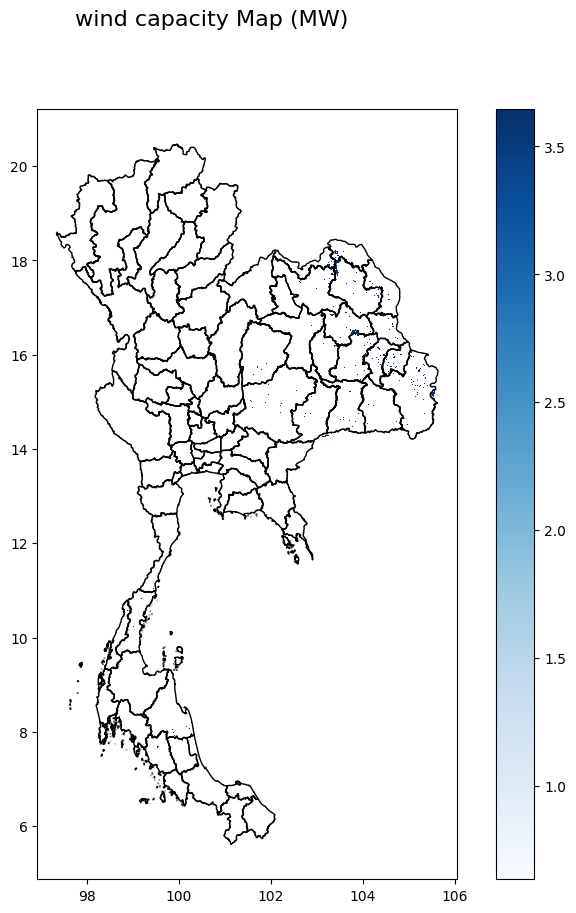

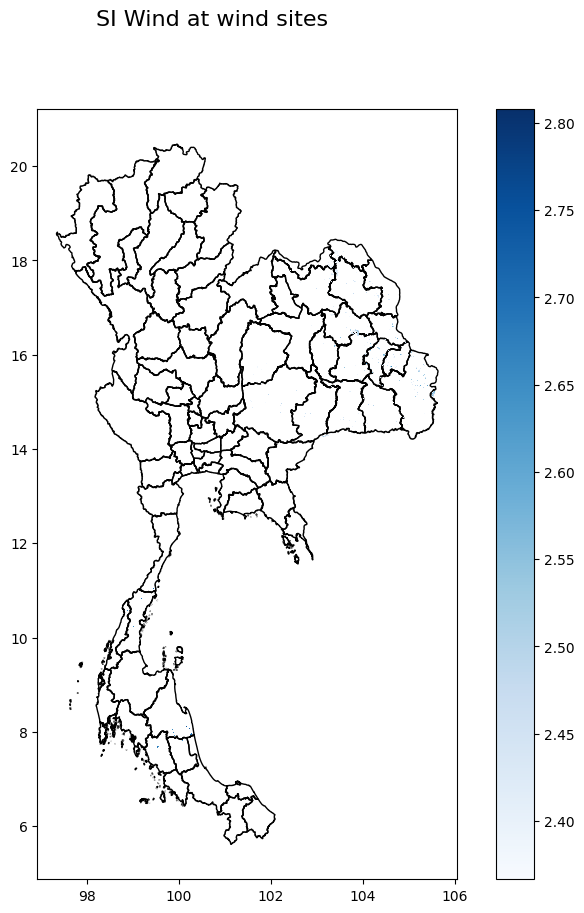

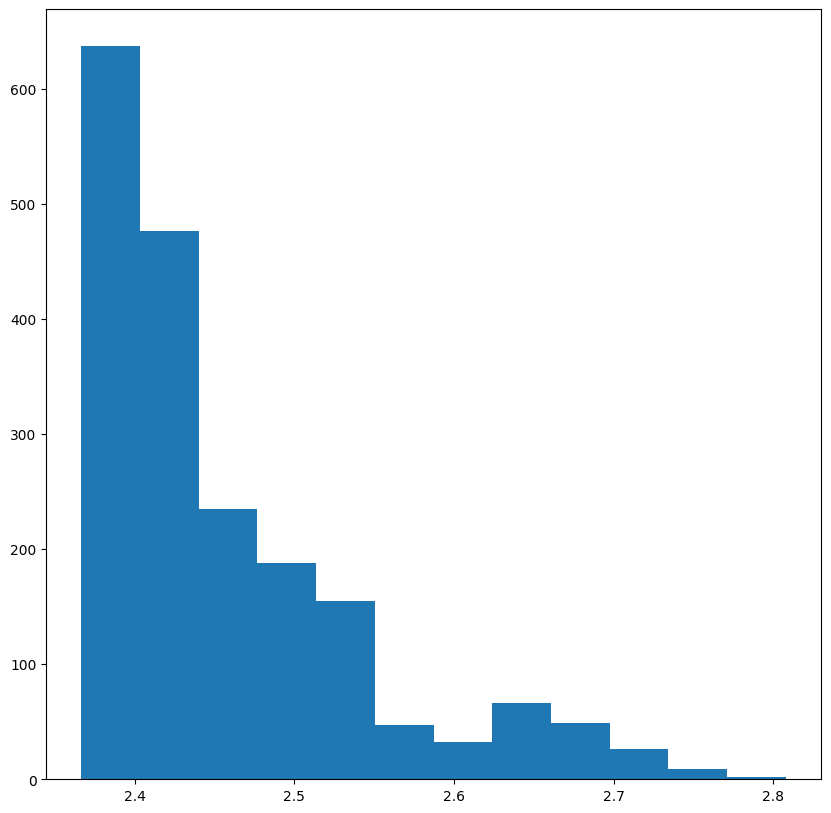

In [24]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

print("total wind capacity = ", df_wind['cap_wind'].sum())
print("R0 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R0'].sum())
print("R1 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R1'].sum())
print("R2 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R2'].sum())
print("R3 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R3'].sum())
print("R4 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('wind capacity Map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind.plot(ax = ax,legend=True,zorder = 1,column = 'cap_wind',cmap = 'Blues')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SI Wind at wind sites', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind.plot(ax = ax,legend=True,zorder = 1,column = 'SI_Wind',cmap = 'Blues')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
plt.hist(df_wind['SI_Wind'],histtype ='barstacked',bins=12)

total solar capacity =  19599.998400000008
R0 Solar =  100.0
R1 Solar =  3499.9997000000008
R2 Solar =  6499.999500000002
R3 Solar =  5999.999500000002
R4 Solar =  3499.9997000000008


(array([290., 185.,  52.,   6.,  26., 211., 469., 218., 105.,  29.,  16.,
          9.]),
 array([2.64488474, 2.66284047, 2.68079621, 2.69875194, 2.71670767,
        2.73466341, 2.75261914, 2.77057488, 2.78853061, 2.80648634,
        2.82444208, 2.84239781, 2.86035354]),
 <BarContainer object of 12 artists>)

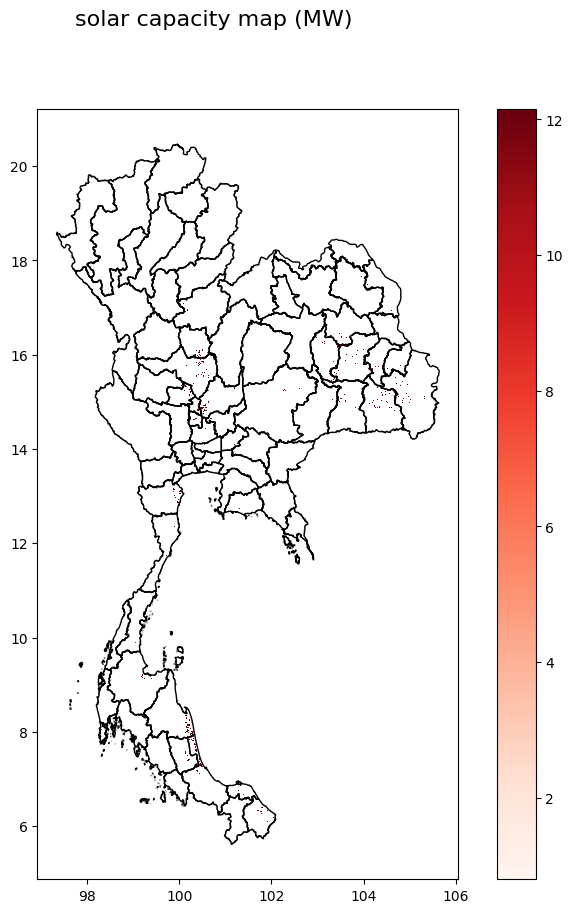

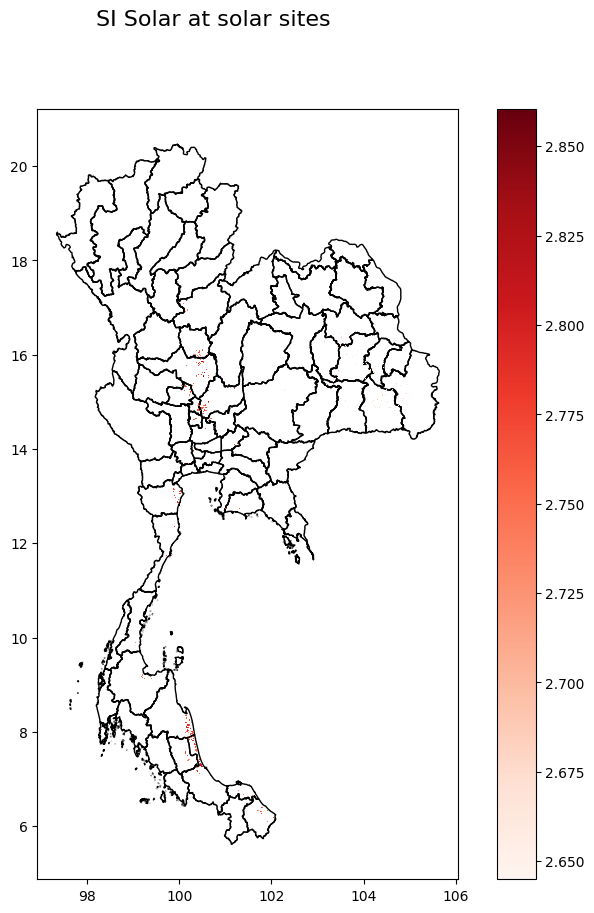

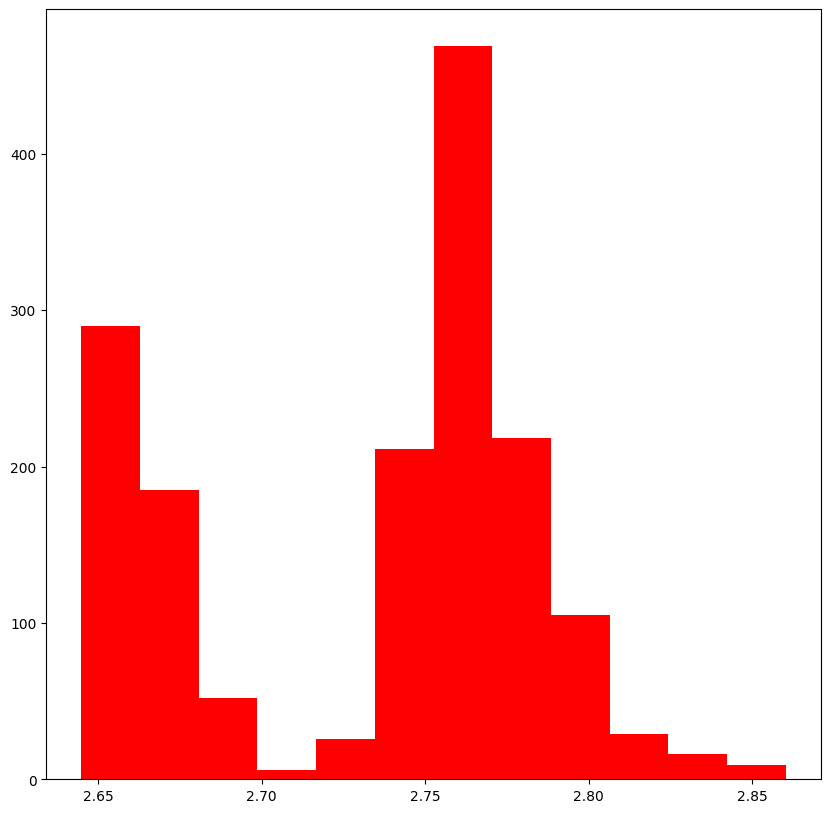

In [25]:
print("total solar capacity = ", df_solar['cap_solar'].sum())
print("R0 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R0'].sum())
print("R1 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R1'].sum())
print("R2 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R2'].sum())
print("R3 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R3'].sum())
print("R4 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('solar capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar.plot(ax = ax,legend=True,zorder = 1,column = 'cap_solar',cmap = 'Reds')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SI Solar at solar sites', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar.plot(ax = ax,legend=True,zorder = 1,column = 'SI_Solar',cmap = 'Reds')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
plt.hist(df_solar['SI_Solar'],histtype ='barstacked',bins=12,color='red')

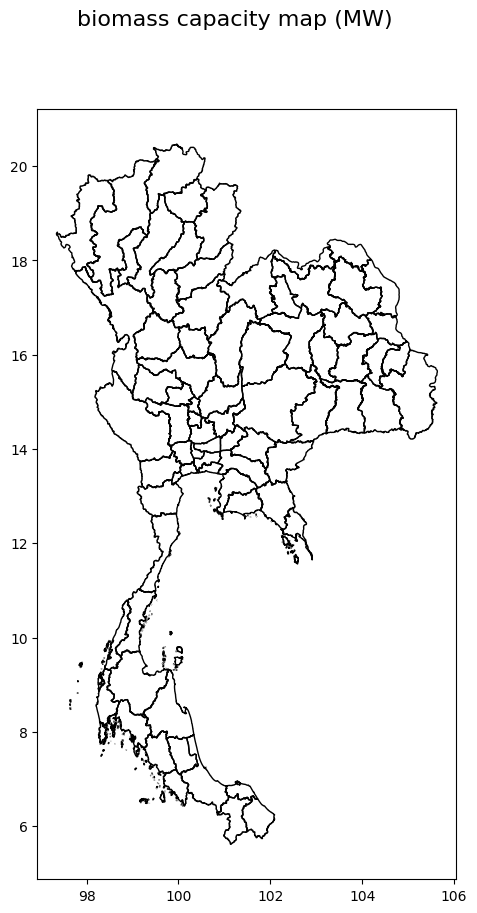

In [26]:
try:
    print("total biomass capacity = ", df_biomass['cap_biomass'].sum())
    print("R0 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R0'].sum())
    print("R1 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R1'].sum())
    print("R2 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R2'].sum())
    print("R3 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R3'].sum())
    print("R4 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R4'].sum())
except:
    None
    
fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('biomass capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_biomass.plot(ax = ax,legend=True,zorder = 1,column = 'cap_biomass',cmap = 'Greens')
except:
    None

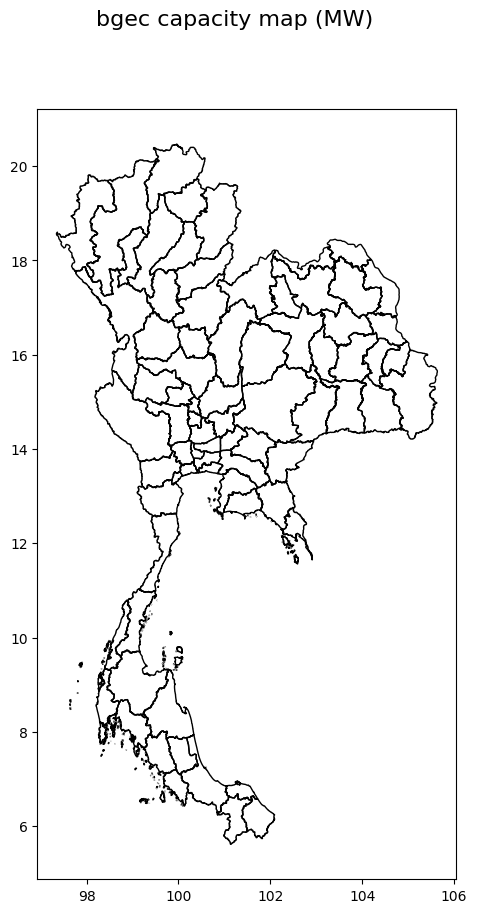

In [27]:
try:
    print("total bgec capacity = ", df_bgec['cap_bgec'].sum())
    print("R0 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R0'].sum())
    print("R1 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R1'].sum())
    print("R2 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R2'].sum())
    print("R3 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R3'].sum())
    print("R4 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R4'].sum())
    
except:
    None

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('bgec capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_bgec.plot(ax = ax,legend=True,zorder = 1,column = 'cap_bgec',cmap = 'Purples')
except:
    None

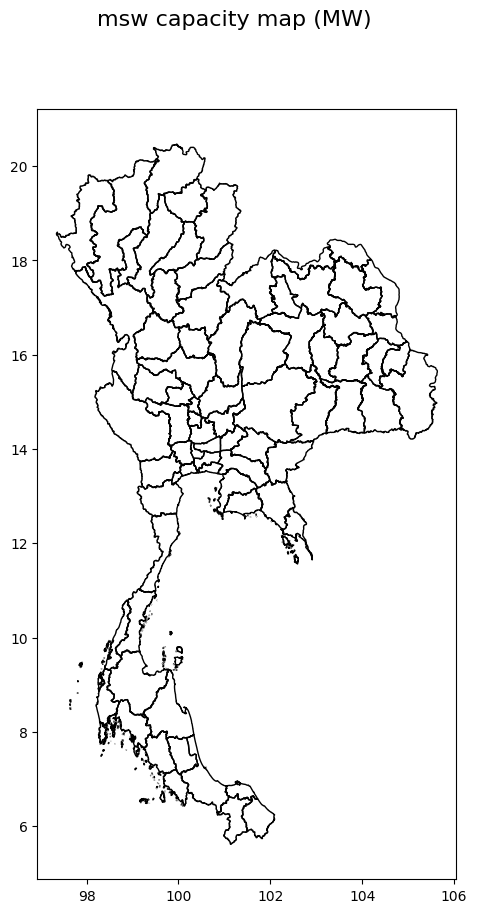

In [28]:
try:
    print("total msw capacity = ", df_msw['cap_msw'].sum())
    print("R0 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R0'].sum())
    print("R1 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R1'].sum())
    print("R2 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R2'].sum())
    print("R3 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R3'].sum())
    print("R4 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R4'].sum())
except:
    None

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('msw capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_msw.plot(ax = ax,legend=True,zorder = 1,column = 'cap_msw',cmap = 'Greys')
except:
    None

In [29]:
region = pd.read_csv('Data\\Region.csv',index_col=False)
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
list_region = []
count = 0
for i in thailandmap['ADM1_TH']:
    r = region['region'].loc[region['province'] == i]
    try : 
        # print(i,r.values[0])
        list_region.append(r.values[0])
    except :
        print(i,'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        list_region.append('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
thailandmap['region'] = list_region

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


C:\Users\595078\AppData\Local\Temp\ipykernel_28880\3039112362.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bound = specificarea.unary_union.bounds


total wind capacity =  6499.999500000002
total solar capacity =  6499.999500000002


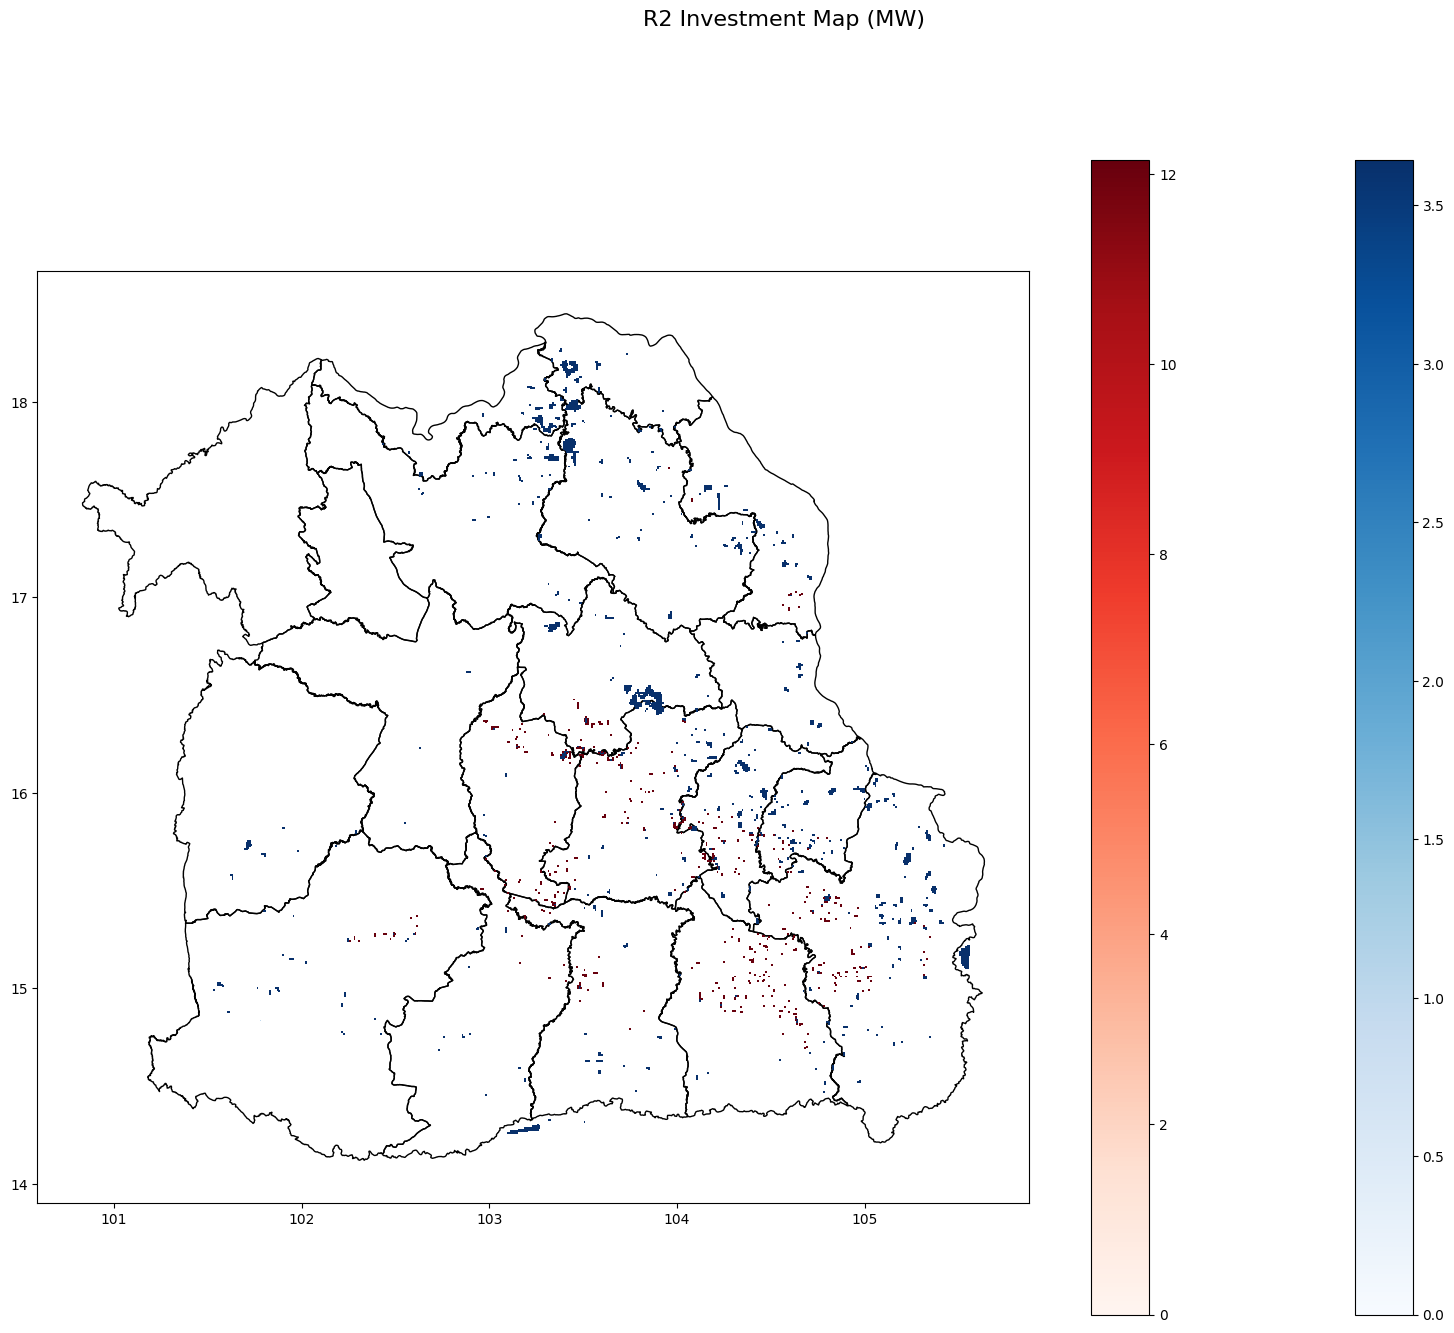

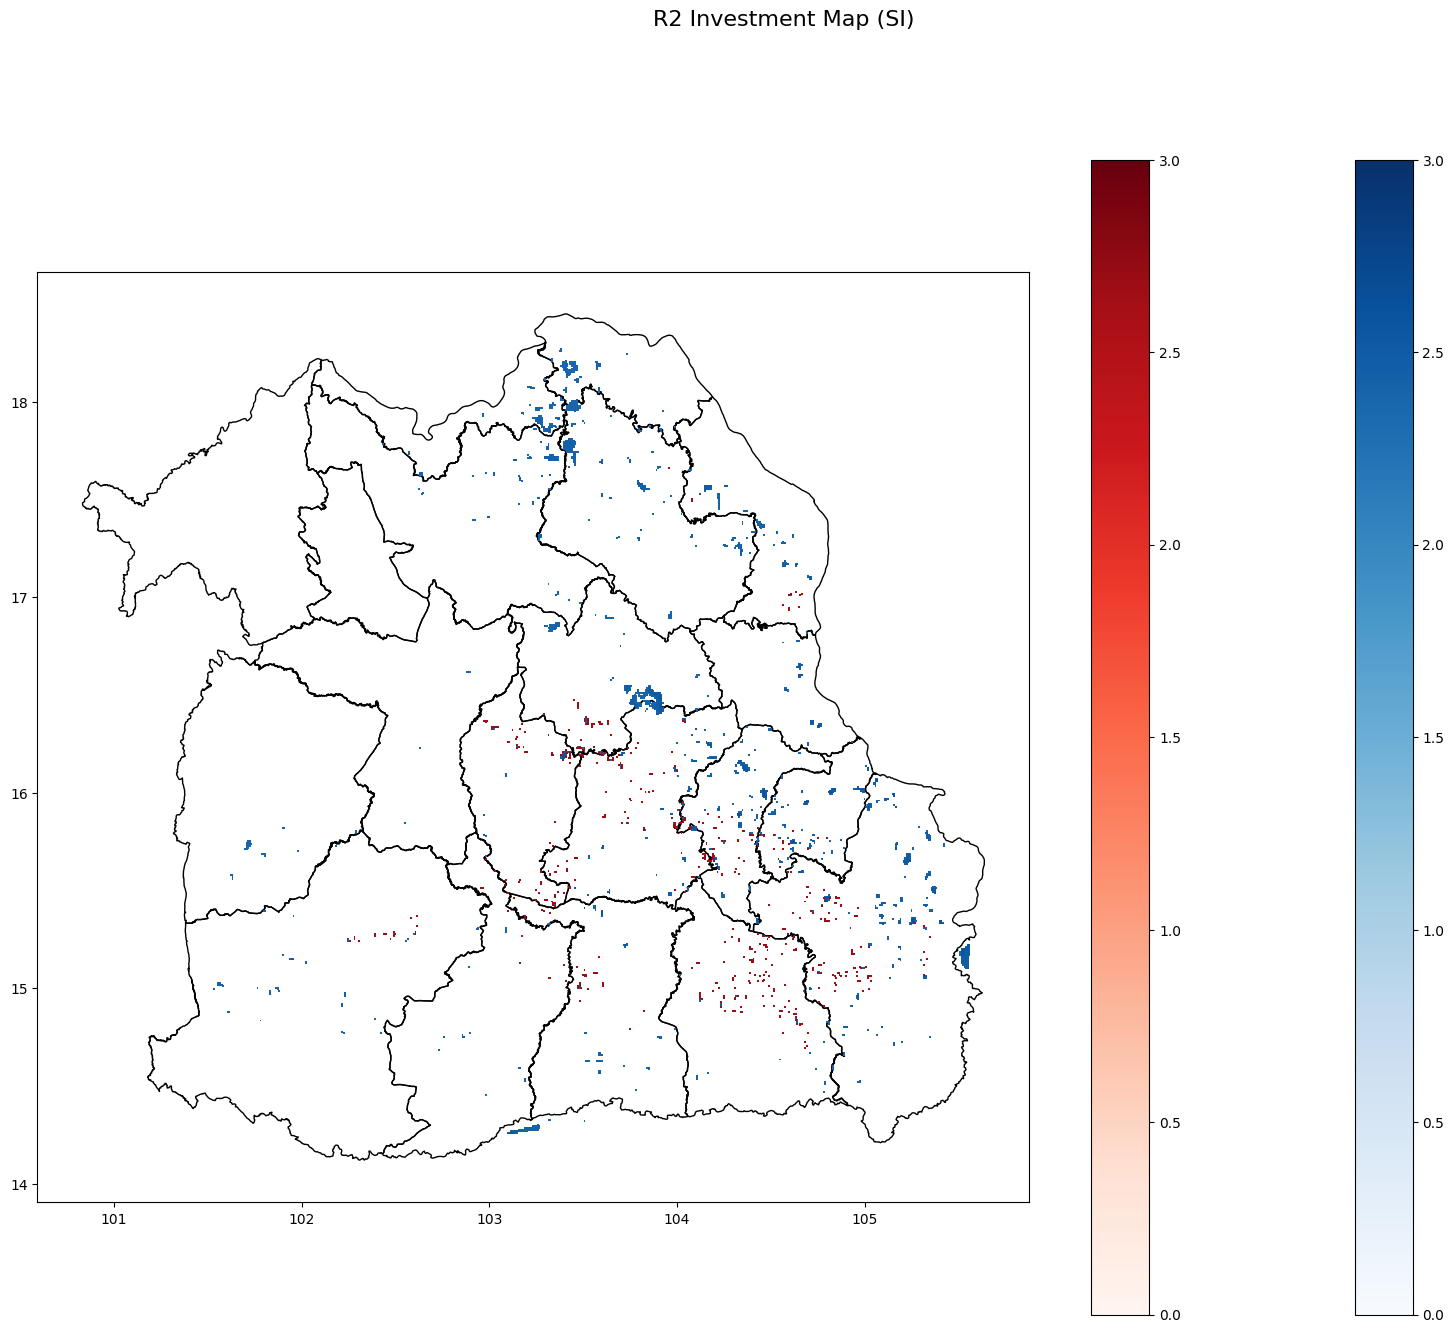

In [39]:
region = 'R2'
specificarea = thailandmap.loc[thailandmap['region'] == region]
bound = specificarea.unary_union.bounds
try:
    print("total wind capacity = ", df_wind['cap_wind'].loc[df_wind['region'] == region].sum())

    print("total solar capacity = ", df_solar['cap_solar'].loc[df_solar['region'] == region].sum())

    print("total biomass capacity = ", df_biomass['cap_biomass'].loc[df_biomass['region'] == region].sum())

    print("total bgec capacity = ", df_bgec['cap_bgec'].loc[df_bgec['region'] == region].sum())

    print("total msw capacity = ", df_msw['cap_msw'].loc[df_msw['region'] == region].sum())

except:
    None

fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle(region + ' Investment Map (MW) ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind.loc[df_wind['region'] == region].plot(ax = ax,legend = True,zorder = 1,column = 'cap_wind',cmap = 'Blues',vmin = 0)
except:
    None
try:
    df_solar.loc[df_solar['region'] == region].plot(ax = ax,legend = True,zorder = 2,column = 'cap_solar',cmap = 'Reds',vmin = 0)
except:
    None
try:
    df_biomass.loc[df_biomass['region'] == region].plot(ax = ax,legend = True,zorder = 3,column = 'cap_biomass',cmap = 'Greens',edgecolors = 'green',vmin = 0)
except:
    None
try:
    df_bgec.loc[df_bgec['region'] == region].plot(ax = ax,legend = True,zorder = 4,column = 'cap_bgec',cmap = 'Purples',edgecolors = 'purple',vmin = 0)
except:
    None
try:
    df_msw.loc[df_msw['region'] == region].plot(ax = ax,legend = True,zorder = 5,column = 'cap_msw',cmap = 'Greys',edgecolors = 'grey',vmin = 0)
except:
    None

fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle(region + ' Investment Map (SI) ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind.loc[df_wind['region'] == region].plot(ax = ax,legend=True,zorder = 1,column = 'SI_Wind',cmap = 'Blues',vmin = 0,vmax=3)
except:
    None
try:
    df_solar.loc[df_solar['region'] == region].plot(ax = ax,legend=True,zorder = 2,column = 'SI_Solar',cmap = 'Reds',vmin = 0,vmax=3)
except:
    None
# try:
#     df_biomass.loc[df_biomass['region'] == region].plot(ax = ax,legend=True,zorder = 3,column = 'SI_Biomass',cmap = 'Greens',edgecolors = 'green',vmin = 0,vmax=3)
# except:
#     None
# try:
#     df_bgec.loc[df_bgec['region'] == region].plot(ax = ax,legend=True,zorder = 4,column = 'SI_BGEC',cmap = 'Purples',edgecolors = 'purple',vmin = 0,vmax=3)
# except:
#     None
# try:
#     df_msw.loc[df_msw['region'] == region].plot(ax = ax,legend=True,zorder = 5,column = 'SI_MSW',cmap = 'Greys',edgecolors = 'grey',vmin = 0,vmax=3)
# except:
#     None